# Coursera Capstone Project
## This Notebook will be used for the Coursera Capstone Final Delivarable Project

## Problem Definition

Many Countries are populated with variety of people encompassing to different faith and different cultures. This leads to the introduction of different kinds of food cuisine in the country. People will like to find and check out a particular cuisine eg: Italian, Chinese etc and would end up recommending it or not for others. They would like to attempt this in a particular manner without missing any cuisine at all and would like to keep a track of it as well. If all the different kinds of restaurants in a particular city can be clustered and arranged in a manner with ratings will give an idea for the customer to devour the cuisine which has appealed the customers attention.  

This data can also be explored in a such manner to find the most sought out cuisine and what would be the appropriate location to open a restaurant as well. 

## Data Description and Processing

Data Processing is the core of machine learning. It is the most time-consuming process of all when compared with other components of machine learning. Thereby requiring scrupulous effort in processing. Therefore, if performed well and properly documented, this would result in an output which would have a high quality in terms of its insight it can provide to stakeholders.

The Data which will be used for the analysis are presented below. 
1. Web Scrape the Wikipedia Table To Obtain The areas around London and its postcodes from https://en.wikipedia.org/wiki/List_of_areas_of_London. 
2. Use geocoder to find the latitude and longitude for each area and update the table.
3. Use Foursquare API to obtain venues around each location for the analysis

Import the necessary Libraries and Install if needed

In [71]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


## Data Obtaining and Cleaning
### 1. Web Scraping of Data From Wikipedia Table

In [72]:
!pip install beautifulsoup4
from bs4 import BeautifulSoup
import requests

In [73]:
#The URL of wikipedia and get html content code
url="https://en.wikipedia.org/wiki/List_of_areas_of_London"
html_content = requests.get(url).text
#pass it beautiful soup 
soup = BeautifulSoup(html_content,'html.parser')

In [74]:
LondonAreas = soup.find("table", attrs={"class": "wikitable"})

In [75]:
def tableDataText(table):       
    rows = []
    trs = table.find_all('tr')
    headerow = [td.get_text(strip=True) for td in trs[0].find_all('th')] # header row
    if headerow: # if there is a header row include first
        rows.append(headerow)
        trs = trs[1:]
    for tr in trs: # for every table row
        rows.append([td.get_text(strip=True) for td in tr.find_all('td')]) # data row
    return rows

In [76]:
list_table = tableDataText(LondonAreas)
columns=(['Location','Borough','Post Town','Postcode','Dial Code','OS grid ref'])
df= pd.DataFrame(list_table[1:], columns=columns)
df.head()
#first remove Dial Code and OS grid ref column 
df=df.drop(['Dial Code','OS grid ref'],axis=1)

Find the shape of the Data

In [77]:
df.shape

(533, 4)

It Can be seen that the table consists of 533 rows and 6 columns. 
When the table is inspected above it can be seen some data cleaning is needed to strip and arrange the data in a manner the anlaysis can be performed.

In [78]:
#Clean the rows where extra character is present with []123456789
df['Borough'] = df['Borough'].str.split('[').str[0]
#strip after the bracket in the Location Column
df['Location'] = df['Location'].str.split('(').str[0]

In [79]:
df.head()

,Location,Borough,Post Town,Postcode
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4"
2,Addington,Croydon,CROYDON,CR0
3,Addiscombe,Croydon,CROYDON,CR0
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14"


In [80]:
#Only London Post Towns Will be analysed therefore everything other London rows drop and remove
df = df[df['Post Town'] == 'LONDON']

In [81]:
df.head()

,Location,Borough,Post Town,Postcode
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4"
6,Aldgate,City,LONDON,EC3
7,Aldwych,Westminster,LONDON,WC2
9,Anerley,Bromley,LONDON,SE20


In [82]:
#Strip unwanted characters 
df['LOC'] = df['Postcode'].str.split(',').str[1]
df['Postcode'] = df['Postcode'].str.split(',').str[0]
print(df.shape)
df.head()

(299, 5)


,Location,Borough,Post Town,Postcode,LOC
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,NaN
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,W3,W4
6,Aldgate,City,LONDON,EC3,NaN
7,Aldwych,Westminster,LONDON,WC2,NaN
9,Anerley,Bromley,LONDON,SE20,NaN


In [83]:
#drop NaN value rows make it another table and join it with previous one and update final table.
df_final=df.dropna()
df_final=df_final.drop(['Postcode'],axis=1)
df_final.rename(columns={'LOC':'Postcode'},inplace=True)
print(df_final.shape)
df_final.dropna()
df_final.head()

(45, 4)


,Location,Borough,Post Town,Postcode
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,W4
10,Angel,Islington,LONDON,N1
15,Arnos Grove,Enfield,LONDON,N14
51,Blackheath Royal Standard,Greenwich,LONDON,SE12
56,Bounds Green,Haringey,LONDON,N22


In [84]:
#drop unwanted columns
df=df.drop(['LOC'],axis=1)
concatenated = df.append(df_final)
concatenated = concatenated.sort_values(by ='Postcode' )
concatenated.head()

,Location,Borough,Post Town,Postcode
482,Upton Park,Newham,LONDON,E13
504,West Ham,Newham,LONDON,E15
284,Leyton,Waltham Forest,LONDON,E15
523,Woodford,Redbridge,LONDON,E18
200,Hackney,Hackney,LONDON,E8


In [85]:
#sort the table according location so same will be on one below
concatenated = concatenated.sort_values(by ='Postcode' )
print(concatenated.shape)

(344, 4)


In [86]:
#make a new index dataseries
df1=pd.Series(range(0,344))
concatenated['INDEX']=pd.Series(range(0,344)).values
df_Lon=concatenated.set_index(['INDEX'])

In [87]:
#print the dataframe before the adjustment for latitudes and longitudes
# as we are working on London towns we can remove the post town column as well. 
df_Lon=df_Lon.drop(['Post Town'],axis=1)
df_Lon.head()

,Location,Borough,Postcode
INDEX,,,
0,Upton Park,Newham,E13
1,West Ham,Newham,E15
2,Leyton,Waltham Forest,E15
3,Woodford,Redbridge,E18
4,Hackney,Hackney,E8


In [88]:
#find how many unique pot codes exist as foursquare limits 50 premium calls analysis has to be limited
df_London_unique = df_Lon['Postcode'].value_counts().to_frame(name='Count')
print('{} Unique Postcodes in London.'.format(df_London_unique.shape[0]))
#df_London_unique = df_London_unique.sort_values(by ='Postcode' )
df_London_unique.head()

151 Unique Postcodes in London.


,Count
NW10,8
E14,8
N1,7
N15,7
E1,7


### 2.Obtaining Longitudes and Latitudes for each Location

In [89]:
!pip install geocoder
import geocoder # import geocoder

In [90]:
#prepare a function to performed on all post codes
def lat_lan_finder(postCode):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, London, United Kingdom'.format(postCode))
        lat_lng_coords = g.latlng
    return lat_lng_coords

### Use the above function and find latitudes and longitudes for each postcode

In [91]:
# Print Database
df_Lon = df_Lon.sort_values(by ='Postcode' )
df_Lon.drop_duplicates(subset ='Postcode',keep ='first', inplace = True)
df_Lon = df_Lon.sort_values(by ='Postcode' )
print('{} Postcodes are in Dataframe.'.format(df_Lon .shape[0]))
df_Lon.head()

151 Postcodes are in Dataframe.


,Location,Borough,Postcode
INDEX,,,
0,Upton Park,Newham,E13
1,West Ham,Newham,E15
3,Woodford,Redbridge,E18
4,Hackney,Hackney,E8
5,Angel,Islington,N1


In [92]:
df_Lon['Latitude']=df_Lon.apply(lambda x: lat_lan_finder(x['Postcode'])[0],axis=1)
df_Lon['Longitude']=df_Lon.apply(lambda x: lat_lan_finder(x['Postcode'])[1],axis=1)

Write to CSV files as time consuming to perform tasks till here.

In [24]:
df_Lon.to_csv(r'df_Lon.csv', index = False)

In [3]:
df_Lon=pd.read_csv('df_Lon.csv')

In [93]:
df_Lon.drop_duplicates(subset ='Postcode',keep ='first', inplace = True)
df_Lon = df_Lon.sort_values(by ='Postcode' )
print(df_Lon.shape)
df_Lon.head()

(151, 5)


,Location,Borough,Postcode,Latitude,Longitude
INDEX,,,,,
0,Upton Park,Newham,E13,51.52653,0.02876
1,West Ham,Newham,E15,51.54014,0.00278
3,Woodford,Redbridge,E18,51.58977,0.03052
4,Hackney,Hackney,E8,51.54505,-0.05532
5,Angel,Islington,N1,51.52969,-0.08697


In [95]:
df_Lon = df_Lon.rename(columns={'Location': 'Neighborhood'})
df_Lon.sort_values(by ='Neighborhood' )

,Neighborhood,Borough,Postcode,Latitude,Longitude
INDEX,,,,,
42,Acton,"Ealing, Hammersmith and Fulham",W4,51.48944,-0.26194
325,Acton,"Ealing, Hammersmith and Fulham",W3,51.51324,-0.26746
341,Aldwych,Westminster,WC2,51.51651,-0.11968
5,Angel,Islington,N1,51.52969,-0.08697
106,Angel,Islington,EC1,51.52361,-0.09877
7,Arnos Grove,Enfield,N14,51.63429,-0.13366
277,Balham,Wandsworth,SW12,51.44822,-0.14839
278,Barnes,Richmond upon Thames,SW13,51.47457,-0.24212
276,Battersea,Wandsworth,SW11,51.46760,-0.16290


It can be seen that only 151 Unique postcodes are there in the dataframe and this simplifies the Foursquare calls

### 3.Foursquare API Data 

In [114]:
#set up foursquare credentials
CLIENT_ID = 'BPK3T2C3F35MBCK5NKFSAZVOHOZ5A4KN35CSUZVULMG50JN0' # your Foursquare ID
CLIENT_SECRET = 'KOVAEEDTUPVDSNALC0MQOIUCNUBRKQT4DHUZRIWPSTFKHDWI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BPK3T2C3F35MBCK5NKFSAZVOHOZ5A4KN35CSUZVULMG50JN0
CLIENT_SECRET:KOVAEEDTUPVDSNALC0MQOIUCNUBRKQT4DHUZRIWPSTFKHDWI


#### Let's explore the first neighborhood in our dataframe.

Find the coordinates and name of the first neighborhood

In [115]:
neighborhood_latitude = df_Lon.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_Lon.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_Lon.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Upton Park are 51.52653000000004, 0.02876000000003387.


#### Now, let's get the top 100 venues that are in Upton Park within a radius of 500 meters.

In [109]:
# type your answer here
LIMIT = 250
radius = 1000
query='restaurants'
categoryId='4d4b7105d754a06374d81259'

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}& categoryId={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    categoryId,
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=YFLOMKVL0MGJSFS1N1M1XOZESWAJDIG04QYRVX0B2BERE5PK&client_secret=4NDWKEZEDQ412LSYXZKEJMD5FI550YJP0DDCSO4KP4005MT3&v=20180605&ll=51.52653000000004,0.02876000000003387& categoryId=4d4b7105d754a06374d81259&radius=1000&limit=250'

In [110]:
results = requests.get(url).json()
#results

In [112]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [113]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns,
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng','venue.id']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

KeyError: 'groups'

In [102]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

22 venues were returned by Foursquare.


In [116]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            categoryId,
            radius,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],  
            v['venue']['id'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue',
                  'ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [130]:
London_venues = getNearbyVenues(names=df_Lon['Neighborhood'],
                                   latitudes=df_Lon['Latitude'],
                                   longitudes=df_Lon['Longitude']
                                  )

Upton Park
West Ham
Woodford
Hackney
Angel
Colney Hatch
Arnos Grove
Stamford Hill
Tottenham
Edmonton
Tufnell Park
Bounds Green
Finchley
Harringay
Neasden
Primrose Hill
Brent Cross
Kensal Green
Elephant and Castle
Blackheath Royal Standard
Ladywell
Newington
Crystal Palace
Sydenham Hill
Tulse Hill
Earls Court
Southfields
Wimbledon
South Kensington
Brixton
North Kensington
Ealing
Little Venice
Acton
Temple
Dartford
Wapping
Leyton
Wanstead
Little Ilford
Plaistow
Isle of Dogs
Maryland
North Woolwich
Walthamstow
South Woodford
Bethnal Green
Old Ford
Chingford
Hackney
East Ham
Forest Gate
Dalston
Homerton
Angel
Tower Hill
Temple
Woodford
Shoreditch
Muswell Hill
Bounds Green
North Finchley
Palmers Green
Osidge
West Green
Stoke Newington
Upper Holloway
Hampstead Garden Suburb
Totteridge
Winchmore Hill
Bowes Park
Church End
Manor House
Highbury
Highgate
Holloway
Turnpike Lane
Edmonton
Somerstown
Brent Park
Golders Green
Dollis Hill
Swiss Cottage
Burroughs, The
Gospel Oak
West Hampstead
The Hale

In [131]:
London_venues.to_csv(r'London_Venues.csv', index = False)

### Restart from Here 

In [132]:
London_venues=pd.read_csv('London_Venues.csv')

In [133]:
print(London_venues.shape)

(3545, 8)


In [134]:
London_venuesunique = London_venues['Venue Category'].value_counts().to_frame(name='Count')
print('{} Unique Restaurants were returned by Foursquare.'.format(London_venuesunique.shape[0]))
London_venuesunique.head()

104 Unique Restaurants were returned by Foursquare.


,Count
Café,537
Italian Restaurant,241
Sandwich Place,193
Bakery,181
Pizza Place,173


Box Plot To Visualise counts for each category.

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

Group Under Postcode or Location to see how many counts for each 

In [121]:
London_venues=London_venues.groupby('Neighborhood').count() 
London_venues.head()
#London_venues.sort_values(by ='ID' )

,Neighborhood Latitude,Neighborhood Longitude,Venue,ID,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
Acton,25,25,25,25,25,25,25
Aldwych,81,81,81,81,81,81,81
Angel,122,122,122,122,122,122,122
Arnos Grove,16,16,16,16,16,16,16
Balham,26,26,26,26,26,26,26


In [39]:
#arrange for maximum to minimum values
df_max_min=London_venues['Neighborhood Latitude'].to_frame()

In [40]:
df_max_min = df_max_min.rename(columns={'Neighborhood Latitude': 'Count'})

In [41]:
df_max_min=df_max_min.sort_values('Count',ascending=False)
df_max_min.head()

,Count
Neighborhood,
Temple,181
Angel,122
Little Venice,104
Fitzrovia,100
Tower Hill,89


From above it can be seen that most venues were returned for Temple Neighborhood location.

In [136]:
# one hot encoding
London_onehot = pd.get_dummies(London_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
London_onehot['Neighborhood'] = London_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [London_onehot.columns[-1]] + list(London_onehot.columns[:-1])
London_onehot = London_onehot[fixed_columns]
print(London_onehot.shape)
London_onehot.head()

(3545, 105)


,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brasserie,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Creperie,Currywurst Joint,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Grilled Meat Restaurant,Halal Restaurant,Hot Dog Joint,Hungarian Restaurant,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Okonomiyaki Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shaanxi Restaurant,Snack Place,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Xinjiang Restaurant
0,Upton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Upton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Upton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Upton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Upton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [137]:
London_onehot_unique = London_onehot['Neighborhood'].value_counts().to_frame(name='Count')
#print('{} Unique Restaurants were returned by Foursquare.'.format(London_onehot_unique.shape[0]))
London_onehot_unique.head()

,Count
Temple,181
Angel,122
Little Venice,104
Fitzrovia,100
Tower Hill,89


No of Occurence of a Venue Category in a Neighborhood

In [138]:
London_grouped1 = London_onehot.groupby('Neighborhood').sum().reset_index()
#London_grouped1 =London_grouped1.set_index('Neighborhood')
London_grouped1.head()

,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brasserie,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Creperie,Currywurst Joint,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Grilled Meat Restaurant,Halal Restaurant,Hot Dog Joint,Hungarian Restaurant,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Okonomiyaki Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shaanxi Restaurant,Snack Place,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Xinjiang Restaurant
0,Acton,0,0,0,0,0,0,0,0,0,3,0,0,0,2,0,1,0,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,Aldwych,0,0,0,1,0,0,0,1,0,4,0,1,0,0,0,3,1,0,9,0,0,4,0,0,2,0,1,1,0,0,1,0,0,1,0,0,1,0,3,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,0,4,5,0,5,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,3,0,0,0,1,5,1,9,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0
2,Angel,0,0,0,0,2,0,0,4,1,0,1,0,1,7,0,3,1,0,12,0,0,2,0,0,0,0,0,0,0,0,1,0,0,1,0,2,4,0,2,0,0,1,10,3,2,3,0,0,0,0,0,0,0,0,0,10,0,2,1,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,5,0,0,0,2,4,1,6,1,1,0,0,2,0,0,0,0,0,1,5,0,1,0,1,3,1,6,0,0
3,Arnos Grove,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,Balham,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,1,0,0,3,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,3,0,0,0,0,0,0,1,1,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


####  Max Data For Subplots

In [139]:
London_grouped1.shape

(133, 105)

In [140]:
#Cafe
cafe=London_grouped1[['Neighborhood','Café']]
cafe=cafe.sort_values('Café',ascending=False)

#Italian Restaurants Italian Restaurant
Italian=London_grouped1[['Neighborhood','Italian Restaurant']]
Italian=Italian.sort_values('Italian Restaurant',ascending=False)

#Sandwich Place
Sandwich=London_grouped1[['Neighborhood','Sandwich Place']]
Sandwich=Sandwich.sort_values('Sandwich Place',ascending=False)

#Bakery
Bakery=London_grouped1[['Neighborhood','Bakery']]
Bakery=Bakery.sort_values('Bakery',ascending=False)

#Pizza Place
PizzaPlace=London_grouped1[['Neighborhood','Pizza Place']]
PizzaPlace=PizzaPlace.sort_values('Pizza Place',ascending=False)

In [141]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

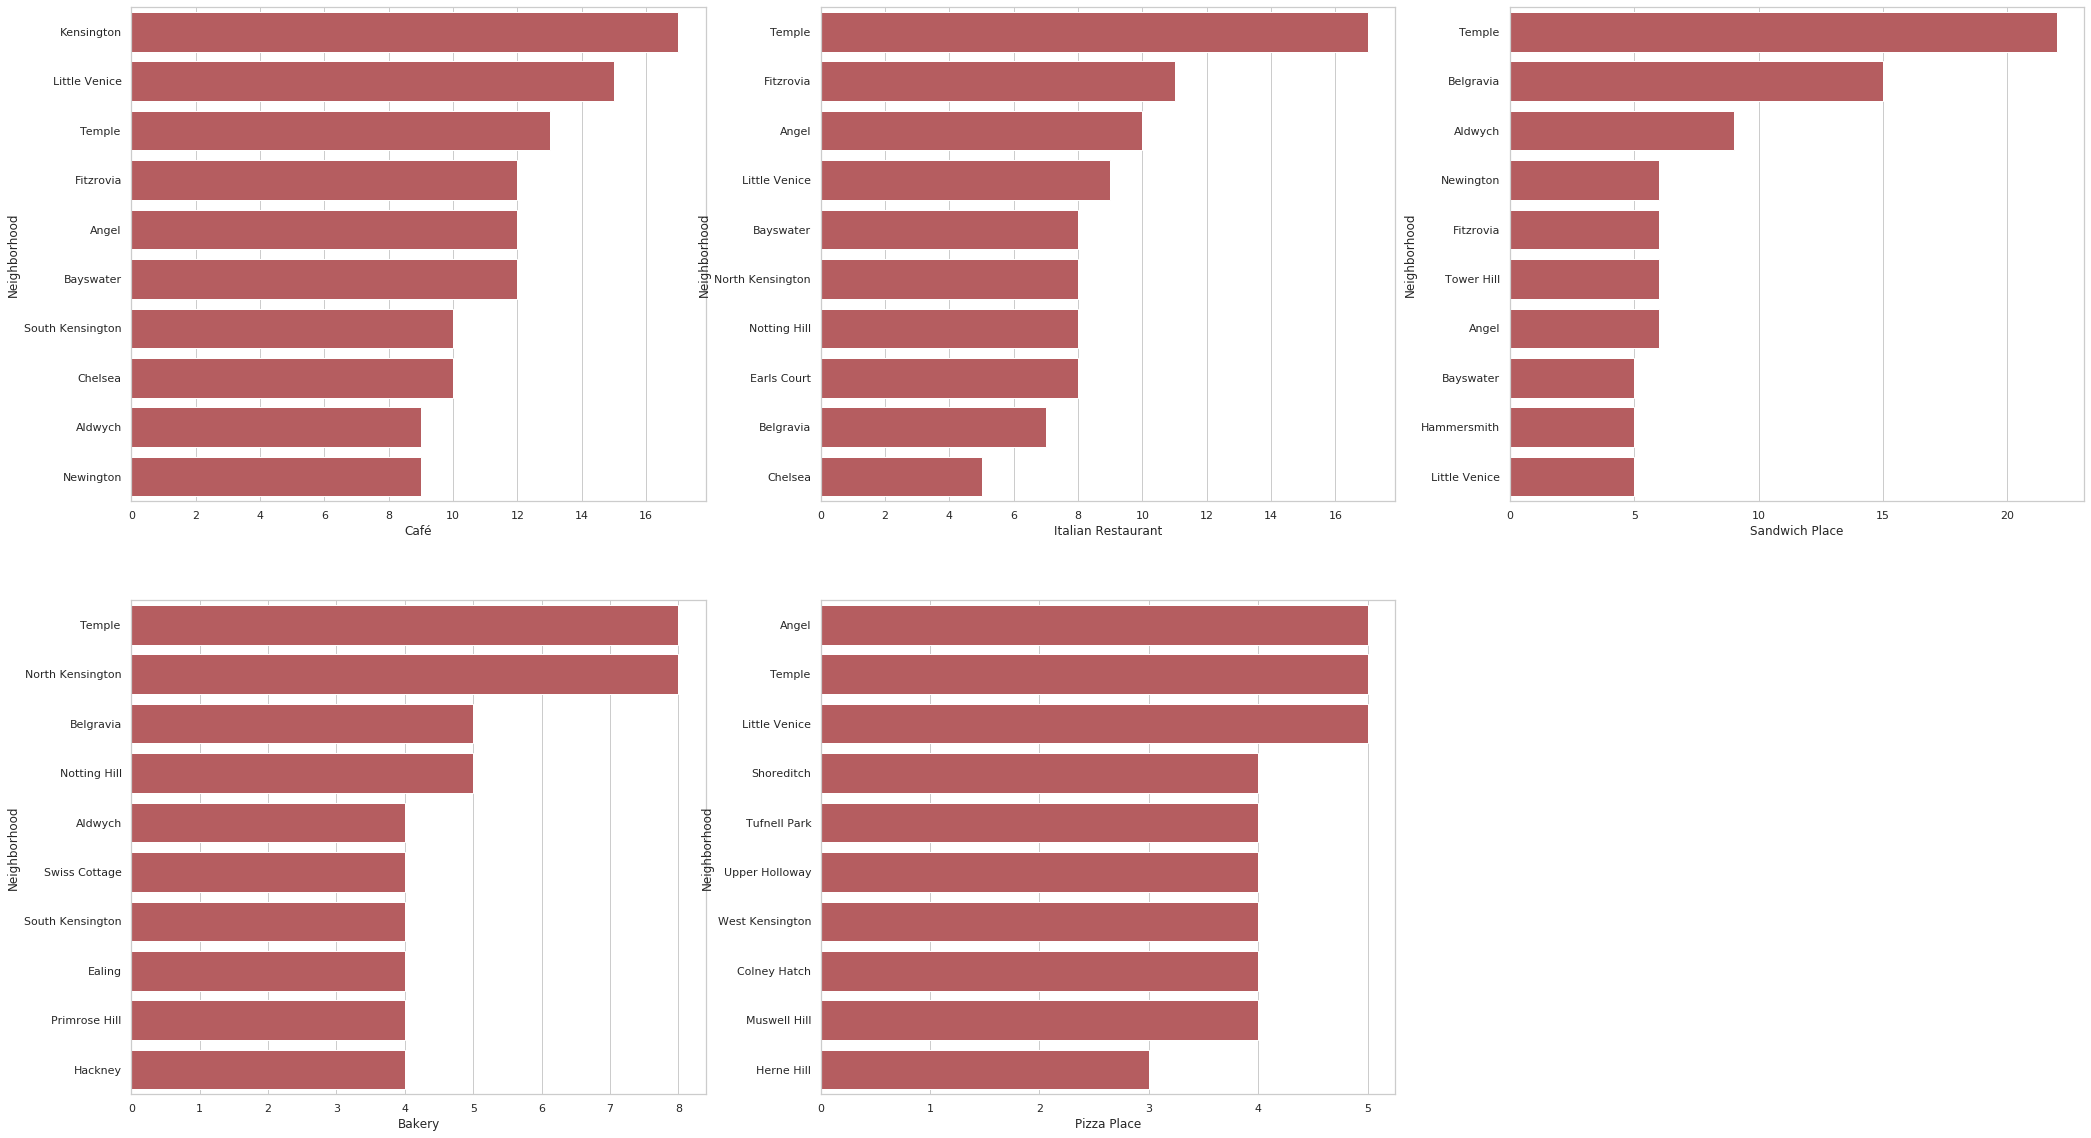

In [142]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(35,20))

#  subplot #1
fig.add_subplot(231)
#plt.title('subplot(231) - title', fontsize=14)
sns.barplot(x=cafe['Café'].iloc[0:10], y=cafe['Neighborhood'].iloc[0:10],color='r', data=cafe)

#  subplot #2
fig.add_subplot(2,3,2)
#plt.title('subplot(2,3,2)', fontsize=14)
sns.barplot(x=Italian['Italian Restaurant'].iloc[0:10], y=Italian['Neighborhood'].iloc[0:10],color='r', data=Italian)


#  subplot #3
fig.add_subplot(233)
#plt.title('subplot(233)', fontsize=14)
sns.barplot(x=Sandwich['Sandwich Place'].iloc[0:10], y=Sandwich['Neighborhood'].iloc[0:10],color='r', data=Sandwich)

#  subplot #4
fig.add_subplot(2,3,4)
#plt.title('subplot(2,3,4)', fontsize=14)
sns.barplot(x=Bakery['Bakery'].iloc[0:10], y=Bakery['Neighborhood'].iloc[0:10],color='r', data=Bakery)

#  subplot #5
fig.add_subplot(235)
#plt.title('subplot(235)', fontsize=14)
sns.barplot(x=PizzaPlace['Pizza Place'].iloc[0:10], y=PizzaPlace['Neighborhood'].iloc[0:10],color='r', data=PizzaPlace)

plt.show()


fig.savefig("output.png")

In [143]:
London_grouped = London_onehot.groupby('Neighborhood').mean().reset_index()
London_grouped.head()

,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brasserie,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Creperie,Currywurst Joint,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Grilled Meat Restaurant,Halal Restaurant,Hot Dog Joint,Hungarian Restaurant,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Okonomiyaki Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shaanxi Restaurant,Snack Place,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Xinjiang Restaurant
0,Acton,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.120000,0.000000,0.000000,0.000000,0.080000,0.0,0.040000,0.000000,0.0,0.160000,0.0,0.000000,0.040000,0.0,0.0,0.040000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.040000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.040000,0.0,0.120000,0.040000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.040000,0.0,0.0,0.040000,0.000000,0.040000,0.000000,0.040000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.04000,0.000000,0.0
1,Aldwych,0.0,0.0,0.0,0.012346,0.000000,0.0,0.0,0.012346,0.000000,0.049383,0.000000,0.012346,0.000000,0.000000,0.0,0.037037,0.012346,0.0,0.111111,0.0,0.000000,0.049383,0.0,0.0,0.024691,0.0,0.012346,0.012346,0.0,0.0,0.012346,0.0,0.0,0.012346,0.0,0.000000,0.012346,0.0,0.037037,0.0,0.0,0.000000,0.000000,0.024691,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.024691,0.0,0.049383,0.061728,0.000000,0.061728,0.0,0.0,0.012346,0.000000,0.012346,0.000000,0.000000,0.012346,0.000000,0.0,0.0,0.0,0.012346,0.0,0.0,0.0,0.037037,0.0,0.0,0.000000,0.012346,0.061728,0.012346,0.111111,0.000000,0.012346,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.012346,0.0,0.000000,0.012346,0.012346,0.00000,0.012346,0.00000,0.012346,0.0
2,Angel,0.0,0.0,0.0,0.000000,0.016393,0.0,0.0,0.032787,0.008197,0.000000,0.008197,0.000000,0.008197,0.057377,0.0,0.024590,0.008197,0.0,0.098361,0.0,0.000000,0.016393,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.008197,0.0,0.0,0.008197,0.0,0.016393,0.032787,0.0,0.016393,0.0,0.0,0.008197,0.081967,0.024590,0.016393,0.024590,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0,0.081967,0.000000,0.016393,0.008197,0.0,0.0,0.000000,0.008197,0.008197,0.008197,0.008197,0.008197,0.008197,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.040984,0.0,0.0,0.000000,0.016393,0.032787,0.008197,0.049180,0.008197,0.008197,0.0,0.0,0.016393,0.0,0.0,0.0,0.0000,0.0,0.008197,0.040984,0.0,0.008197,0.000000,0.008197,0.02459,0.008197,0.04918,0.000000,0

In [144]:
London_grouped.shape

(133, 105)

In [145]:
num_top_venues = 5

for hood in London_grouped1['Neighborhood']:
    print("----"+hood+"----")
    temp = London_grouped1[London_grouped1['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
   # print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')

----Acton----
----Aldwych----
----Angel----
----Arnos Grove----
----Balham----
----Barnes----
----Battersea----
----Bayswater----
----Belgravia----
----Bethnal Green----
----Blackheath Royal Standard----
----Bounds Green----
----Bowes Park----
----Brent Cross----
----Brent Park----
----Brixton----
----Burroughs, The----
----Catford----
----Charlton----
----Chelsea----
----Chingford----
----Church End----
----Clapham----
----Colney Hatch----
----Crystal Palace----
----Dalston----
----Dartford----
----Denmark Hill----
----Deptford----
----Dollis Hill----
----Ealing----
----Earls Court----
----East Dulwich----
----East Ham----
----Edmonton----
----Elephant and Castle----
----Finchley----
----Fitzrovia----
----Forest Gate----
----Gipsy Hill----
----Golders Green----
----Gospel Oak----
----Greenwich----
----Grove Park----
----Hackney----
----Hammersmith----
----Hampstead Garden Suburb----
----Hanwell----
----Harringay----
----Herne Hill----
----Highbury----
----Highgate----
----Hither Green

In [146]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [147]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = London_grouped1['Neighborhood']

for ind in np.arange(London_grouped1.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(London_grouped1.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acton,Café,Bakery,Italian Restaurant,French Restaurant,Breakfast Spot,Restaurant,Burger Joint,English Restaurant,Portuguese Restaurant,Chinese Restaurant
1,Aldwych,Sandwich Place,Café,Korean Restaurant,Restaurant,Japanese Restaurant,Chinese Restaurant,Bakery,Italian Restaurant,Burger Joint,Fish & Chips Shop
2,Angel,Café,Italian Restaurant,Food Truck,Breakfast Spot,Sandwich Place,Vietnamese Restaurant,Pizza Place,Sushi Restaurant,BBQ Joint,Restaurant
3,Arnos Grove,Fast Food Restaurant,Pizza Place,Café,Spanish Restaurant,Italian Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Portuguese Restaurant,Sandwich Place
4,Balham,Fish & Chips Shop,Indian Restaurant,Café,Fast Food Restaurant,Bakery,Breakfast Spot,Pizza Place,Chinese Restaurant,Portuguese Restaurant,Caucasian Restaurant


### 4.Machine Learning

Let's Cluster the Restaurants instead of cities

In [148]:
# set number of clusters
kclusters = 5

London_grouped_clustering = London_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(London_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

In [173]:
len(kmeans.labels_)

133

In [150]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Acton,Café,Bakery,Italian Restaurant,French Restaurant,Breakfast Spot,Restaurant,Burger Joint,English Restaurant,Portuguese Restaurant,Chinese Restaurant
1,4,Aldwych,Sandwich Place,Café,Korean Restaurant,Restaurant,Japanese Restaurant,Chinese Restaurant,Bakery,Italian Restaurant,Burger Joint,Fish & Chips Shop
2,4,Angel,Café,Italian Restaurant,Food Truck,Breakfast Spot,Sandwich Place,Vietnamese Restaurant,Pizza Place,Sushi Restaurant,BBQ Joint,Restaurant
3,1,Arnos Grove,Fast Food Restaurant,Pizza Place,Café,Spanish Restaurant,Italian Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Portuguese Restaurant,Sandwich Place
4,4,Balham,Fish & Chips Shop,Indian Restaurant,Café,Fast Food Restaurant,Bakery,Breakfast Spot,Pizza Place,Chinese Restaurant,Portuguese Restaurant,Caucasian Restaurant


In [152]:
London_df=pd.read_csv('df_Lon.csv')
London_df = London_df.rename(columns={'Location': 'Neighborhood'})

In [153]:
merged_inner = pd.merge(left=neighborhoods_venues_sorted, right=London_df, left_on='Neighborhood', right_on='Neighborhood')
merged_inner.drop_duplicates(subset ='Neighborhood',keep ='first', inplace = True)

In [154]:
merged_inner.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough,Postcode,Latitude,Longitude
0,2,Acton,Café,Bakery,Italian Restaurant,French Restaurant,Breakfast Spot,Restaurant,Burger Joint,English Restaurant,Portuguese Restaurant,Chinese Restaurant,"Ealing, Hammersmith and Fulham",W4,51.48944,-0.26194
2,4,Aldwych,Sandwich Place,Café,Korean Restaurant,Restaurant,Japanese Restaurant,Chinese Restaurant,Bakery,Italian Restaurant,Burger Joint,Fish & Chips Shop,Westminster,WC2,51.51651,-0.11968
3,4,Angel,Café,Italian Restaurant,Food Truck,Breakfast Spot,Sandwich Place,Vietnamese Restaurant,Pizza Place,Sushi Restaurant,BBQ Joint,Restaurant,Islington,N1,51.52969,-0.08697
5,1,Arnos Grove,Fast Food Restaurant,Pizza Place,Café,Spanish Restaurant,Italian Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Portuguese Restaurant,Sandwich Place,Enfield,N14,51.63429,-0.13366
7,4,Balham,Fish & Chips Shop,Indian Restaurant,Café,Fast Food Restaurant,Bakery,Breakfast Spot,Pizza Place,Chinese Restaurant,Portuguese Restaurant,Caucasian Restaurant,Wandsworth,SW12,51.44822,-0.14839


In [155]:
merged_inner.shape

(133, 16)

In [285]:
sum_of_squared_distances = []
K = range(1,30)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(London_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

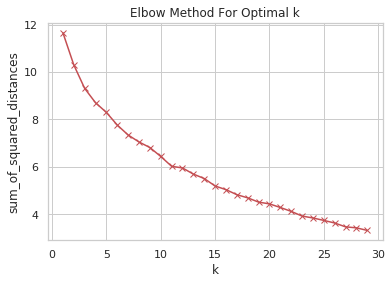

In [287]:
plt.plot(K, sum_of_squared_distances, 'rx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

In [290]:
from sklearn.metrics import silhouette_score

sil = []
K_sil = range(2,30)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(London_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(London_grouped_clustering, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

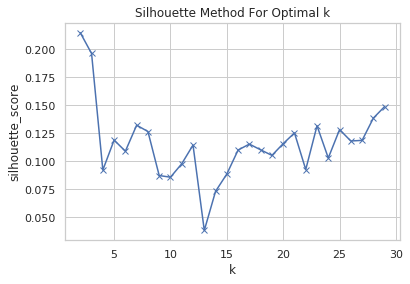

In [291]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

Use 9 as K for performing Clustering 

In [156]:
# set number of clusters
kclusters = 9

London_grouped_clustering = London_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(London_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 1, 0, 4, 2, 2, 1, 1, 2], dtype=int32)

In [157]:
London_grouped_clustering.shape

(133, 104)

In [158]:
London_df=pd.read_csv('df_Lon.csv')
London_df = London_df.rename(columns={'Location': 'Neighborhood'})

In [159]:
merged_inner = pd.merge(left=neighborhoods_venues_sorted, right=London_df, left_on='Neighborhood', right_on='Neighborhood')
merged_inner.drop_duplicates(subset ='Neighborhood',keep ='first', inplace = True)

In [199]:
merged_inner.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough,Postcode,Latitude,Longitude
0,2,Acton,Café,Bakery,Italian Restaurant,French Restaurant,Breakfast Spot,Restaurant,Burger Joint,English Restaurant,Portuguese Restaurant,Chinese Restaurant,"Ealing, Hammersmith and Fulham",W4,51.48944,-0.26194
2,4,Aldwych,Sandwich Place,Café,Korean Restaurant,Restaurant,Japanese Restaurant,Chinese Restaurant,Bakery,Italian Restaurant,Burger Joint,Fish & Chips Shop,Westminster,WC2,51.51651,-0.11968
3,4,Angel,Café,Italian Restaurant,Food Truck,Breakfast Spot,Sandwich Place,Vietnamese Restaurant,Pizza Place,Sushi Restaurant,BBQ Joint,Restaurant,Islington,N1,51.52969,-0.08697
5,1,Arnos Grove,Fast Food Restaurant,Pizza Place,Café,Spanish Restaurant,Italian Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Portuguese Restaurant,Sandwich Place,Enfield,N14,51.63429,-0.13366
7,4,Balham,Fish & Chips Shop,Indian Restaurant,Café,Fast Food Restaurant,Bakery,Breakfast Spot,Pizza Place,Chinese Restaurant,Portuguese Restaurant,Caucasian Restaurant,Wandsworth,SW12,51.44822,-0.14839


In [201]:
# create map
map_clusters = folium.Map(location=[51.48944, -0.26194], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged_inner['Latitude'], merged_inner['Longitude'], merged_inner['Neighborhood'], merged_inner['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


### Cluster 0

In [202]:
map_clusters.save('map.html')

In [217]:
cluster_0=merged_inner.loc[merged_inner['Cluster Labels'] == 0, merged_inner.columns[[1] + list(range(2, merged_inner.shape[1]))]]

In [232]:
required_column_indices = [2]
required_column = [list(merged_inner.columns.values)[i] for i in required_column_indices]
required_column_indices = [2]

for col in required_column:
    print('Cluster 0')
    print(cluster_0[col].value_counts(ascending = False))
   
    print("---------------------------------------------")

Cluster 0
Café                    13
Fast Food Restaurant     2
Fried Chicken Joint      2
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------


### Cluster 1

In [221]:


cluster_1=merged_inner.loc[merged_inner['Cluster Labels'] == 1, merged_inner.columns[[1] + list(range(2, merged_inner.shape[1]))]]


In [233]:
for col in required_column:
    print('Cluster 1')
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

Cluster 1
Café                    7
Pizza Place             4
Fast Food Restaurant    3
Turkish Restaurant      1
Italian Restaurant      1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------


In [223]:
cluster_2=merged_inner.loc[merged_inner['Cluster Labels'] == 2, merged_inner.columns[[1] + list(range(2, merged_inner.shape[1]))]]

In [234]:
for col in required_column:
    print('Cluster 2')
    print(cluster_2[col].value_counts(ascending = False))
    print("---------------------------------------------")

Cluster 2
Café                     39
Indian Restaurant         3
Italian Restaurant        2
Vietnamese Restaurant     1
Bakery                    1
Asian Restaurant          1
Pizza Place               1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------


In [235]:
for col in required_column:
    print('Cluster 3')
    print(cluster_3[col].value_counts(ascending = False))
    print("---------------------------------------------")

Cluster 3
Bakery    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------


In [225]:
cluster_3=merged_inner.loc[merged_inner['Cluster Labels'] == 3, merged_inner.columns[[1] + list(range(2, merged_inner.shape[1]))]]

In [227]:
cluster_4=merged_inner.loc[merged_inner['Cluster Labels'] == 4, merged_inner.columns[[1] + list(range(2, merged_inner.shape[1]))]]

In [236]:
for col in required_column:
    print('Cluster 4')
    print(cluster_4[col].value_counts(ascending = False))
    print("---------------------------------------------")

Cluster 4
Café                     11
Indian Restaurant        10
Fast Food Restaurant      8
Sandwich Place            5
Chinese Restaurant        3
Pizza Place               2
Turkish Restaurant        2
Fish & Chips Shop         2
Restaurant                2
Portuguese Restaurant     1
Japanese Restaurant       1
Italian Restaurant        1
French Restaurant         1
Fried Chicken Joint       1
Burger Joint              1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------


In [186]:
merged_inner.loc[merged_inner['Cluster Labels'] == 5, merged_inner.columns[[1] + list(range(5, merged_inner.shape[1]))]]

,Neighborhood,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough,Postcode,Latitude,Longitude


In [187]:
merged_inner.loc[merged_inner['Cluster Labels'] == 6, merged_inner.columns[[1] + list(range(5, merged_inner.shape[1]))]]

,Neighborhood,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough,Postcode,Latitude,Longitude


In [188]:
merged_inner.loc[merged_inner['Cluster Labels'] == 7, merged_inner.columns[[1] + list(range(5, merged_inner.shape[1]))]]

,Neighborhood,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough,Postcode,Latitude,Longitude


In [189]:
merged_inner.loc[merged_inner['Cluster Labels'] == 8, merged_inner.columns[[1] + list(range(5, merged_inner.shape[1]))]]

,Neighborhood,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough,Postcode,Latitude,Longitude
